<div style="text-align:center">
<span style="color:red; font-size:2em; font-weight: bold">Social Media Network Analytics - Assignment 1</span>

## __Name: Harry Marshall__
## __Student ID: s4015845__
</div>

## __Data Collection__
### Connect to Reddit Client

In [ ]:
# create a reddit client that will gather all the data.
from redditClient import redditClient

# name of subreddit the data is collected from.
subreddit_name= ''
retrieved_result_limit = 5000

# construct reddit client.
client = redditClient()

# access the subreddit.
subreddit = client.subreddit(subreddit_name)
# print subreddit title.
print(subreddit.title)
# print subreddit descp.
print(subreddit.description)

Stocks - Investing and trading for all
Almost any post related to stocks is welcome; please read the rules below:

[**If you're new here**](https://www.reddit.com/r/stocks/comments/4x1419/if_youre_new_here_read_this_post_first/)

##Resources

* [Wiki for new investors](https://www.reddit.com/r/stocks/wiki/index)

* [Pattern day trading](https://www.reddit.com/r/stocks/wiki/pdtrules)

* [Earnings calendar](https://finance.yahoo.com/calendar/earnings/)

##Karma requirements

[Click here to find how many days old your account needs to be and how much karma you need](https://www.reddit.com/r/stocks/wiki/karma) before you can comment or post to r/Stocks.

##Rules [(in depth rules wiki here)](https://www.reddit.com/r/stocks/wiki/rules)

1. Disclose any related open positions when discussing a particular stock or financial instrument.

2. Spam, ads, solicitations (including referral links), and self-promotion posts or comments will be removed and you might get banned.  Instead, [advertise her

### Amount of Subreddit Submissions in a Month

In [ ]:
# understand the amount of reddit posts made in a month.
import praw
from datetime import datetime, timedelta

# calculate date range.
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=30)
start_timestamp = int(start_date.timestamp())

print(f"Counting posts in r/{subreddit_name} from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# init post count.
post_count = 0

# use 'new' sorting to get posts.
for submission in subreddit.new(limit=None):
    # check if we're within our time range.
    if submission.created_utc < start_timestamp:
        # stop searching after a months worth of posts.
        break
        
    post_count += 1
    
    # print progress every 100 posts.
    if post_count % 100 == 0:
        print(f"Counted {post_count} posts so far...")

# print result.
print(f"\nRESULTS:")
print(f"Total posts in r/{subreddit_name} in the past 30 days: {post_count}")
print(f"Average posts per day: {post_count / 30:.2f}")

### Get and Structure Subreddit Submissions and Comments

In [ ]:
# obtain months worth of reddit posts.
import json
from praw.models import MoreComments
from datetime import datetime
import time

# create a json file name.
output_filename = f'../json/{subreddit_name}-submissions-raw.json'
submissions_json = []

# 750 posts have been made in a month.
for index, submission in enumerate(subreddit.new(limit=retrieved_result_limit)):
    if index % 100 == 0:
        print(f"Collected {index + 1} submissions...")

    submission_data = {
        "submission_id": submission.id,
        "submission_date": submission.created_utc,
        "submission_title": submission.title,
        "submission_author": str(submission.author) if submission.author else "[deleted]",
        "submission_score": submission.score,
        "submission_upvote_ratio": submission.upvote_ratio,
        "submission_num_comments": submission.num_comments,
        "submission_text": submission.selftext if submission.is_self else "",
        # Empty list to hold comments later if needed
        "submission_comments": [] 
    }

    if submission.num_comments > 0:
        comments_list = [comment for comment in submission.comments.list() if not isinstance(comment, MoreComments)]

        for i, comment in enumerate(comments_list):

            if i >= 35:
                break 

            comment_data = {
                "comment_id": comment.id,
                "comment_author": str(comment.author) if comment.author else "[deleted]",
                "comment_score": comment.score,
                "comment_text": comment.body,
                "comment_num_replies": len(comment.replies) if hasattr(comment, "replies") else 0
            }

            submission_data['submission_comments'].append(comment_data)

    submissions_json.append(submission_data)
    time.sleep(0.5)

# final header struct of json file.
final_data = {
    "subreddit": subreddit_name,
    "collection_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "total_posts": len(submissions_json),
    "posts": submissions_json
}

# save to JSON file.
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(final_data, f, indent=2, ensure_ascii=False)
    print('json data saved')

## __Exploratory Data Analysis__

### Get the Unique and most Active Users 

In [ ]:
from praw.models import MoreComments
from collections import Counter

# specify which subreddit we are interested in.
subreddit = client.subreddit(subreddit_name)

l_post_author = []
l_comment_author = []

# obtain the hot submissions for this subreddit.
for submission in subreddit.hot(limit=750):
    # print title, but we can print other information of each submission as well.
    if submission.author is not None:
        l_post_author.append(submission.author.name)

    # check submission has comments.
    if submission.num_comments > 0:
        # remove all MoreComments class from list.
        comments_list = [comment for comment in submission.comments.list() if not isinstance(comment, MoreComments)]
        # stop after 35 comments.
        for i, comment in enumerate(comments_list):
            if i >= 35:
                break

            if comment.author is not None:
                l_comment_author.append(comment.author.name)

post_names_counter = Counter(l_post_author)
comment_names_counter = Counter(l_comment_author)

# print the results of post authors.
print(f"Post submission authors: {post_names_counter}")
print(f"Number of Users: {len(post_names_counter)}")

# print the results of comment authors.
print(f"Post submission authors: {comment_names_counter}")
print(f"Number of Users: {len(comment_names_counter)}")

## __Data Preprocessing__

### Text Tokenisation and Stemming

In [5]:
import string
import re
import nltk
nltk.download('stopwords')

def process_text(text):

    # Tweet tokeniser.
    tokenizer = nltk.tokenize.TweetTokenizer()
    l_punct = list(string.punctuation)
    # Add custom stopwords to the standard list
    additional_stopwords = [
        'would', 'could', 'also', 'like', 'one', 'go', 'see', 'think', 'make',
        'get', 'take', 'look', 'know', 'want', 'say', 'said', 'even', 'still',
        'much', 'many', 'back', 'good', 'new', 'this', 'that', 'these', 'those',
        'has', 'had', 'was', 'were', 'been', 'being', 'have', 'any', 'some'
    ]
    stop_words = nltk.corpus.stopwords.words('english') + l_punct + ['via'] + additional_stopwords
    stemmer = nltk.stem.PorterStemmer()

    # Define stock ticker pattern.
    ticker_pattern = r'\$?[A-Z]{2,5}'
    ticker_pattern_2 = r'[A-Z]{1,2}\&[A-Z]{1,2}'

    # Extract potential stock tickers before any processing.
    potential_tickers = set(re.findall(ticker_pattern, text))
    potential_tickers_2 = set(re.findall(ticker_pattern_2, text))
    potential_tickers.update(potential_tickers_2)

    # print known abbreviations. 
    print(potential_tickers)
    
    # convert to lower case, but AFTER extracting tickers.
    text_lower = text.lower()
    
    # get rid of all urls.
    text_lower = re.sub(r'https?://\S+|www\.\S+', '', text_lower)
    
    # filter out emoticons and other noisy characters.
    text_lower = ''.join(char for char in text_lower if char.isalnum() or char.isspace() or char in string.punctuation)
    
    # tokenise text.
    l_tokens = tokenizer.tokenize(text_lower)
    # store original length of text.
    original_word_count = len(l_tokens)
    
    # Strip whitespaces.
    l_tokens = [token.strip() for token in l_tokens]
    
    # Remove very short tokens and stopwords early, but keep potential stock tickers
    l_tokens = [token for token in l_tokens if 
                (token.upper() in potential_tickers) or  # Keep if it's a potential ticker
                (len(token) > 2 and  
                token not in stop_words and 
                not token.isdigit() and 
                token != "'" and token != "''" and
                token != "..." and token != "…")]
    
    # now stem only the normal words, but leave stock tickers untouched
    l_stemmed_tokens = set()
    for tok in l_tokens:
        if tok.upper() in potential_tickers:
            # Keep tickers in uppercase to highlight them
            l_stemmed_tokens.add(tok.upper())
        else:
            # Stem regular words
            l_stemmed_tokens.add(stemmer.stem(tok))
    
    # calc the word count after tokenisation.
    final_word_count = len(l_stemmed_tokens)
    
    # calculate dropped words.
    words_dropped = original_word_count - final_word_count
    return list(l_stemmed_tokens), words_dropped, original_word_count

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harrymarshall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Save new JSON file with Preprocessed Text
##### Using process_text() function on natural language.
##### Printing names of stocks and financial acronyms.

In [6]:
import json
from collections import Counter

# collected submission json file.
input_filename = f'../datasets/{subreddit_name}-submissions-raw.json'
output_filename = f'../datasets/{subreddit_name}-submissions-token.json'

# number of most frequent terms to display.
freq_num = 85

# term freq counter.
term_freq_counter = Counter()

# attributes in the json struct that need to be tokenised.
tokenised_submission = [
    'submission_title',
    'submission_text',
]

total_words_dropped = 0
total_words_dataset = 0

# open JSON file and process submissions.
with open(input_filename, 'r', encoding='utf-8') as f:
    d_submissions = json.load(f)

    for submission in d_submissions['posts']:

        for var in tokenised_submission:
            submission_text = submission.get(var, '')
            l_tokens, submission_words_dropped, submission_words = process_text(submission_text)
            # replace original text with tokenized version.
            submission[var] = ' '.join(l_tokens)
            term_freq_counter.update(l_tokens)

            total_words_dropped += submission_words_dropped
            total_words_dataset += submission_words

        for comment in submission['submission_comments']:
            comment_text = comment.get('comment_text', '')
            l_tokens, comment_words_dropped, comment_words = process_text(comment_text)
            # replace original text with tokenized version.
            comment['comment_text'] = ' '.join(l_tokens)

            term_freq_counter.update(l_tokens)

            total_words_dropped += comment_words_dropped
            total_words_dataset += comment_words

# save the tokenised data to a new JSON file.
with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(d_submissions, f, ensure_ascii=False, indent=2)

print(f"Amount of words in text fields: {total_words_dataset}")
print(f"Amount of words dropped: {total_words_dropped}")
# print out most common terms.
ranking = 1
for term, count in term_freq_counter.most_common(freq_num):
    print(str(ranking) + ': ' + term + ': ' + str(count))
    ranking += 1


set()
{'LYV', 'MRNA', 'US', 'NMAX', 'FDA', 'JNJ', 'THIRD', 'DJT', 'RFK', 'NVAX', 'IPO'}
set()
{'MACD', 'RSI', 'ATR', 'TA', 'VWAP'}
set()
{'DELL', 'DOGED', 'AI'}
{'IPO'}
{'TSMC', 'US', 'NVDA', 'MRVL', 'AMD', 'TSM', 'QCOM', 'MCHP', 'TXN', 'MU'}
set()
set()
set()
{'MOC', 'JPM'}
set()
set()
set()
set()
{'$CELH'}
set()
{'NMAX'}
{'NT', 'IPO', 'IT'}
{'DS', 'VAL'}
{'BSX'}
{'AAPL'}
{'QQQ', 'VOO', 'SCHG', 'SP'}
set()
set()
set()
set()
{'RIP', 'S&P'}
set()
{'IBM'}
{'DJT'}
set()
set()
set()
set()
set()
set()
set()
set()
{'LSEG'}
set()
{'EU', 'US', 'AM'}
{'FUD'}
set()
{'EU', 'US'}
{'US'}
{'SP', 'FUD', 'ED', 'ALK', 'UD', 'IT'}
{'OR', 'ATH'}
{'US', 'SP'}
{'EU', 'US'}
set()
set()
{'BYD', 'SZ', 'EV', 'PFA'}
set()
{'TSLA'}
set()
{'TSLA'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'BYD'}
set()
set()
set()
set()
set()
set()
set()
{'BYD'}
{'BYD', 'CNY', 'USD'}
set()
set()
set()
set()
set()
set()
{'YOUR'}
set()
set()
{'ETF'}
set()
set()
set()
set()
set()
set()
set()
{'SE', 'AXON', 'M

### Plot Most Frequent Words

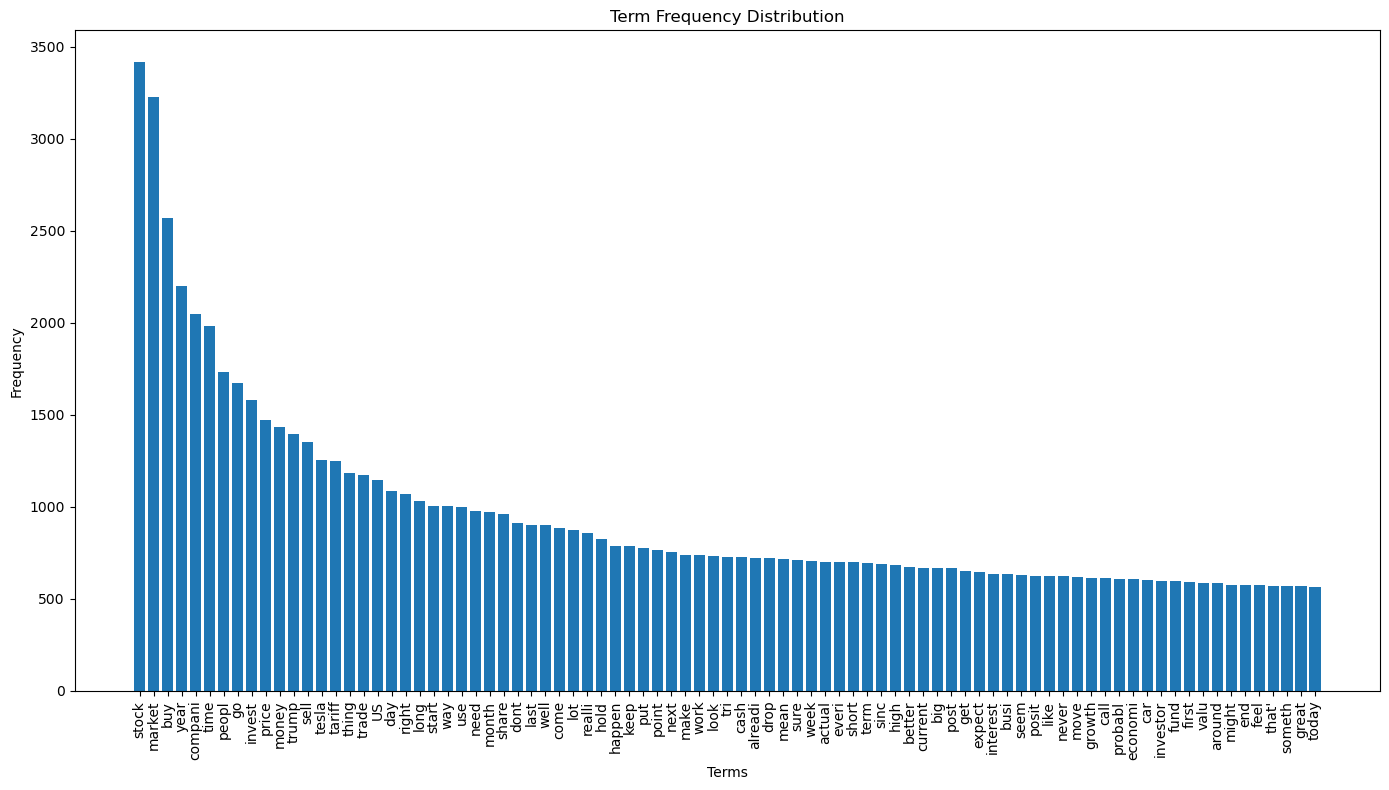

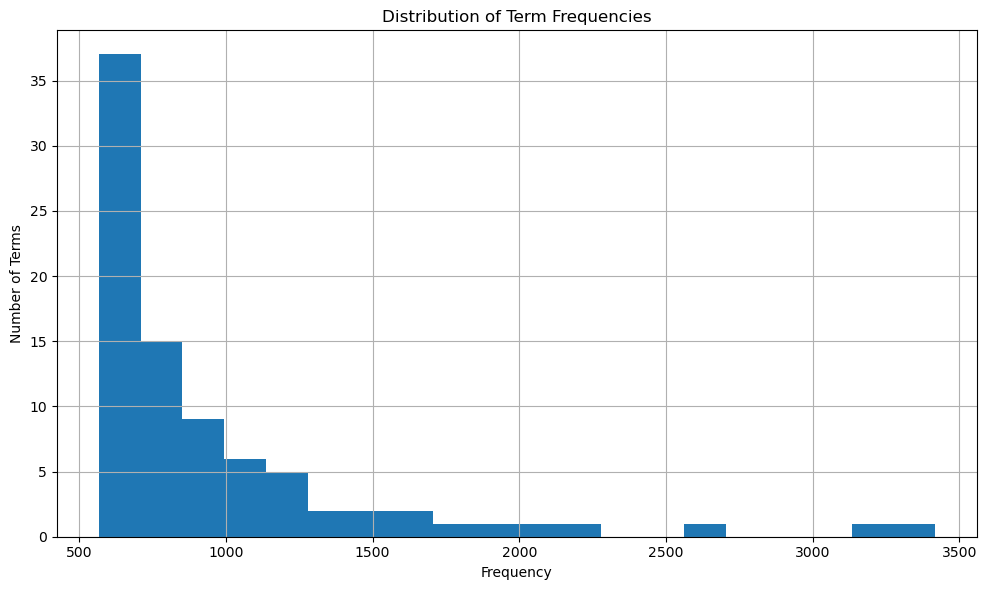

In [7]:
import matplotlib.pyplot as plt

# get the most common terms,
most_common = term_freq_counter.most_common(freq_num)

# create histogram of term frequencies.
terms, counts = zip(*most_common)

# create a bar chart.
plt.figure(figsize=(14, 8))
plt.bar(range(len(terms)), counts, align='center')
plt.xticks(range(len(terms)), terms, rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Term Frequency Distribution')
plt.tight_layout()
plt.show()

# create a histogram of frequency values to show the distribution pattern.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=20)
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.title('Distribution of Term Frequencies')
plt.grid(True)
plt.tight_layout()
plt.show()

##  __Method and Modelling__

### Load Sentiment Analysis and Slang Words

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

custom_lexicon = {
    # Bullish terms (positive)
    'moon': 3.0,
    'mooning': 3.0,
    'bull': 2.0,
    'bullish': 2.5,
    'long': 1.0,
    'calls': 1.5,
    'hodl': 1.0,
    'tendies': 2.0,
    'rocket': 2.5,
    'rocketship': 2.5,
    'yolo': 1.5,
    'buy the dip': 1.5,
    'btd': 1.5,
    'ath': 2.0,
    'breakout': 1.5,
    'outperform': 1.5,
    'upgrade': 1.0,
    'beat': 1.0,
    
    # Bearish terms (negative)
    'bear': -2.0,
    'bearish': -2.5,
    'short': -1.0,
    'puts': -1.5, 
    'bagholder': -2.0,
    'sell off': -1.5,
    'dump': -2.0,
    'crash': -3.0,
    'recession': -2.5,
    'drilling': -2.0,
    'tanking': -2.5,
    'guh': -2.0,
    'rugpull': -3.0,
    'fud': -1.5,
    'underperform': -1.5,
    'downgrade': -1.0,
    'miss': -1.0,
}
    

stemmed_lexicon = {}
for word, score in custom_lexicon.items():
    stemmed_tokens, _, _ = process_text(word)
    
    # Join into a string if there are tokens
    if stemmed_tokens:
        stemmed_word = ' '.join(stemmed_tokens)
        stemmed_lexicon[stemmed_word] = score

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Update VADER's lexicon with our stemmed custom lexicon
sia.lexicon.update(stemmed_lexicon)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harrymarshall/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Compute Sentiment Function

In [9]:
def compute_sentiment(l_tokens):
    
    return sia.polarity_scores(l_tokens)

### Average Sentiment Analysis of Submissions

In [10]:
import json
import datetime

# import tokenised submission JSON file.
input_filename = f'../datasets/{subreddit_name}-submissions-token.json'
output_json = f'../datasets/{subreddit_name}-submissions-tf-idf.json'
output_csv = f'../datasets/{subreddit_name}-submissions-tf-idf.csv'

# Variables for text fields
tokenised_submission = [
    'submission_title',
    'submission_text',
]

# Dictionary to store submission data
submission_texts = {}
submission_metadata = {}
submission_topics = {}
all_topics = set()

# Open JSON file and process submissions
with open(input_filename, 'r', encoding='utf-8') as f:
    d_submissions = json.load(f)
    
    # Extract text from each submission and its comments
    for submission in d_submissions['posts']:
        submission_id = submission.get('submission_id', '')
        combined_text = ""
        sentiment_total = 0  # Renamed from combined_sentiment to avoid conflict
        num_sentiment_items = 0
        
        # Get timestamp information
        created_utc = submission.get('submission_date', '')
        if created_utc:
            try:
                date_time = datetime.datetime.fromtimestamp(float(created_utc))
            except:
                date_time = None
        else:
            date_time = None
        
        # Get submission text fields
        for var in tokenised_submission:
            submission_text = submission.get(var, '')
            if submission_text:
                sentiment_score = compute_sentiment(submission_text)
                print(sentiment_score['compound'])
                sentiment_total += sentiment_score['compound']
                num_sentiment_items += 1
                combined_text += " " + submission_text
        
        # Get comment text fields
        for comment in submission.get('submission_comments', []):
            comment_text = comment.get('comment_text', '')
            if comment_text:
                sentiment_score = compute_sentiment(comment_text)  # Changed from combined_sentiment to compute_sentiment
                sentiment_total += sentiment_score['compound']
                num_sentiment_items += 1
                combined_text += " " + comment_text
        
        # Calculate average sentiment
        avg_sentiment = sentiment_total / num_sentiment_items if num_sentiment_items > 0 else 0
        
        # Store the combined text and metadata for this submission
        submission_texts[submission_id] = combined_text.strip()
        submission_metadata[submission_id] = {
            'date': date_time.strftime('%Y-%m-%d') if date_time else '',
            'time': date_time.strftime('%H:%M:%S') if date_time else '',
            'timestamp': date_time.timestamp() if date_time else None,
            'sentiment': avg_sentiment,
            'num_comments': len(submission.get('submission_comments', [])),
            'topics': []  # Will be filled after TF-IDF
        }

0.4588
-0.9584
0.0
0.9169
-0.5423
-0.7351
-0.5719
-0.2263
0.5423
-0.2509
0.2263
0.91
-0.7351
-0.5267
0.0
-0.1779
-0.6249
0.875
-0.6739
-0.25
0.296
-0.3818
0.0
0.2263
-0.2732
-0.5574
0.0
0.3612
-0.6705
-0.9382
0.6124
-0.6222
0.0
-0.25
0.0
0.9001
0.0
0.8271
-0.25
-0.128
0.0
-0.2523
-0.2732
0.1335
0.0
0.25
0.0
-0.3612
0.0
0.0
0.4588
-0.937
0.0
0.5541
0.0
0.5994
0.2263
-0.9211
0.6369
0.0516
-0.5423
-0.7215
0.0
-0.1974
0.0
-0.34
0.0
0.8807
0.0
-0.0516
-0.296
0.6486
0.0
-0.3226
0.0
0.9571
0.0
0.516
0.0
0.9357
0.4019
0.8722
0.0
0.0
0.0
-0.4914
0.4417
0.3818
-0.5423
0.4767
0.0
0.8885
0.0
0.9432
0.296
0.7351
-0.25
0.4094
-0.3612
0.8481
0.2023
-0.0772
0.2732
0.4588
0.0
-0.4215
0.0
0.4588
0.0
0.5402
0.0
0.5423
0.0
0.872
0.0
0.5994
0.0
-0.4767
0.0
-0.6517
-0.6249
0.6597
-0.3612
0.2732
0.3818
-0.34
0.0
0.8834
0.0
0.9068
0.0
-0.9243
0.0
-0.7783
0.0
-0.2023
0.0
0.4215
0.0772
0.6705
0.3818
0.3818
0.0
-0.1779
0.0
0.802
0.0
0.8426
0.0
0.3612
0.0
-0.6369
0.296
0.296
-0.4767
-0.4416
0.296
0.9746
0.0
0.965

### TF-IDF (Term Frequency-Inverse Document Frequency)

### Analyse the Topics of Submissions

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create corpus from all submission texts.
corpus = list(submission_texts.values())
submission_ids = list(submission_texts.keys())

# create TF-IDF. 
tfidf_vectorizer = TfidfVectorizer(
    # >80% of documents.
    max_df=0.8,  
    # min doc word count. 
    min_df=3,
    # top 500 features.
    max_features=500,
    # ignore single words or phrases.
    ngram_range=(1, 2)
)

# fit the vectorizer to the corpus.
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# get feature names.
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")

# get top terms for each submission based on TF-IDF scores.
for i, submission_id in enumerate(submission_ids):
    # get the document vector.
    doc_vector = tfidf_matrix[i].toarray()[0]
    
    # get indices of top 10 TF-IDF scores.
    top_indices = doc_vector.argsort()[-10:][::-1]
    
    # get corresponding terms and their scores.
    top_terms_with_scores = [(feature_names[idx], doc_vector[idx]) for idx in top_indices if doc_vector[idx] > 0]
    top_terms = [term for term, score in top_terms_with_scores]

    # store as the topic for this submission
    submission_topics[submission_id] = top_terms
    # update metadata
    submission_metadata[submission_id]['topics'] = top_terms
    
    # add to overall set of topics
    all_topics.update(top_terms)

Number of features: 500


### Topic Focused Data Structure

In [12]:
# create a topic-oriented view.
topic_analysis = {}
for topic in all_topics:
    # find all submissions containing this topic.
    relevant_submissions = [
        sub_id for sub_id, topics in submission_topics.items() 
        if topic in topics
    ]
    
    # calculate average sentiment for this topic.
    sentiments = [submission_metadata[sub_id]['sentiment'] for sub_id in relevant_submissions if submission_metadata[sub_id]['sentiment'] != 0]
    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    
    # get timestamps for temporal analysis.
    timestamps = [submission_metadata[sub_id]['timestamp'] for sub_id in relevant_submissions 
                 if submission_metadata[sub_id]['timestamp'] is not None]
    
    # store topic data.
    topic_analysis[topic] = {
        'count': len(relevant_submissions),
        'avg_sentiment': avg_sentiment,
        'submissions': relevant_submissions,
        'earliest_mention': min(timestamps) if timestamps else None,
        'latest_mention': max(timestamps) if timestamps else None
    }

In [13]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for easier analysis and graphing
rows = []
for submission_id, metadata in submission_metadata.items():
    for topic in metadata['topics']:
        rows.append({
            'submission_id': submission_id,
            'date': metadata['date'],
            'time': metadata['time'],
            'timestamp': metadata['timestamp'],
            'sentiment': metadata['sentiment'],
            'num_comments': metadata['num_comments'],
            'topic': topic
        })

df = pd.DataFrame(rows)

# Save the DataFrame for later visualization
df.to_csv(output_csv, index=False)

# Save the full analysis results to JSON
results = {
    'submission_metadata': submission_metadata,
    'submission_topics': submission_topics,
    'topic_analysis': {k: v for k, v in topic_analysis.items() if k},
    'all_topics': list(all_topics)
}

print(f"Found {len(all_topics)} unique topics across {len(submission_texts)} submissions")

Found 500 unique topics across 855 submissions


### Display Most Common Topics Frequency

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


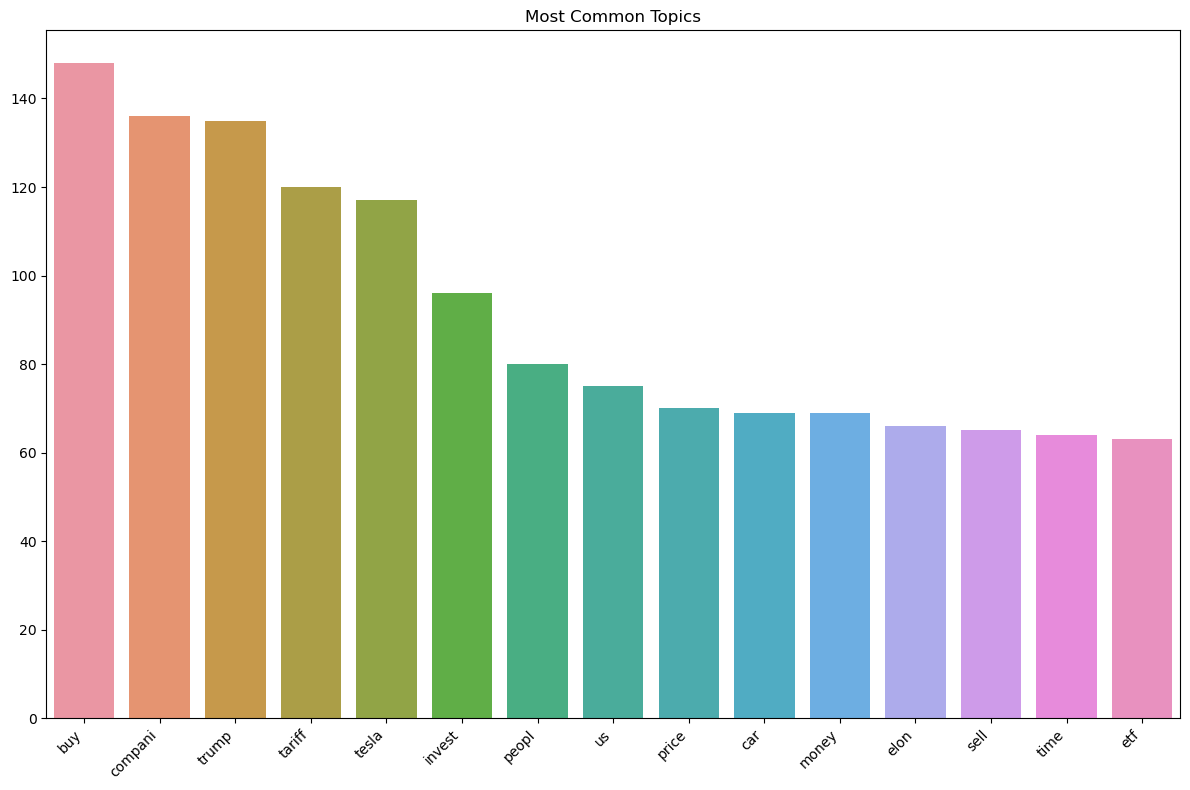

In [14]:
# 1. Most common topics
topic_counts = Counter([topic for topics_list in submission_topics.values() for topic in topics_list])
top_topics = topic_counts.most_common(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=[topic for topic, _ in top_topics], y=[count for _, count in top_topics])
plt.title('Most Common Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_topics.png')

### Display Most Common Topics Sentiment Distributions

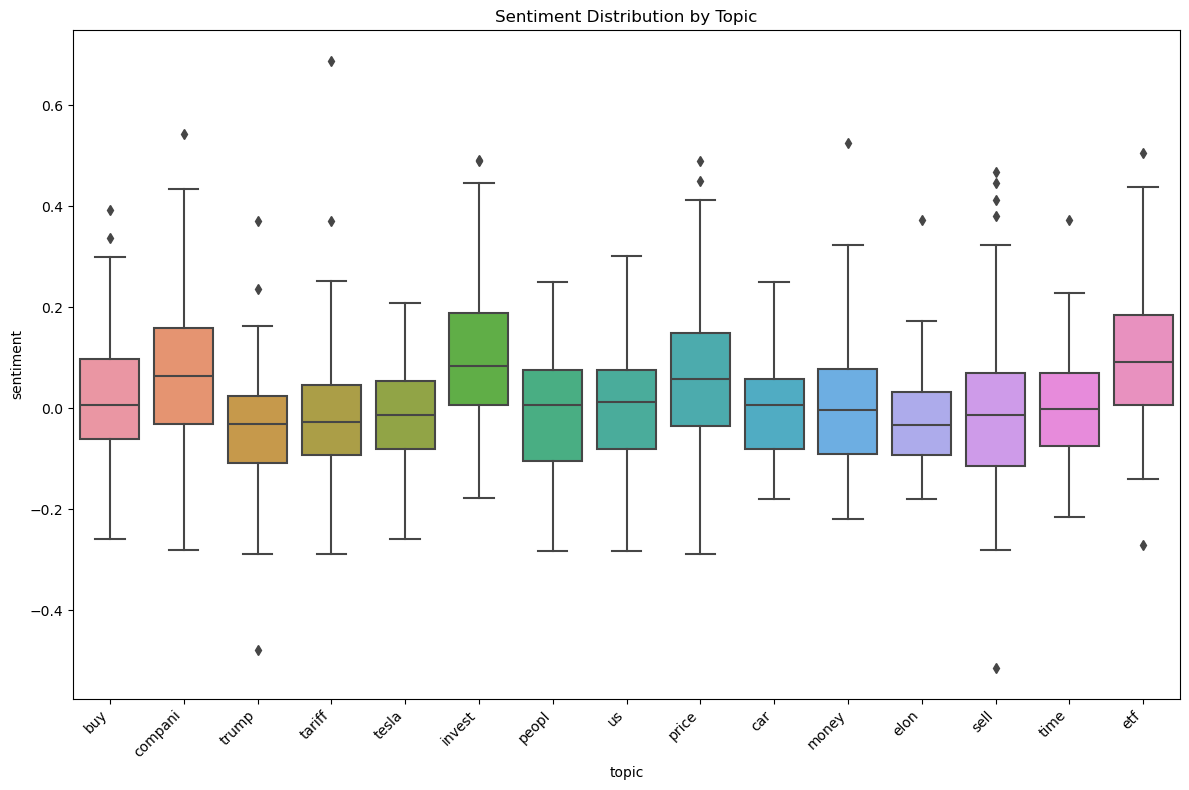

In [15]:
# 2. Sentiment distribution by top topics
top_topic_names = [topic for topic, _ in top_topics[:15]]
topic_sentiments = df[df['topic'].isin(top_topic_names)]
# Get topics in order of frequency
ordered_topics = [topic for topic, _ in top_topics[:15]]

# Use this order in the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='topic', y='sentiment', data=topic_sentiments, order=ordered_topics)
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('topic_sentiments.png')

### Most Common Topics Highest and Lowest Rated Submissions

In [16]:
#  3. Print min and max sentiment submission IDs for top 5 topics
print("\n--- Min/Max Sentiment Submission IDs for Top 5 Topics ---")
for topic, count in top_topics[:5]:
    print(f"\nTopic: {topic} (Count: {count})")
    
    # Get relevant submissions and their sentiment scores
    topic_submissions = []
    for sub_id in topic_analysis[topic]['submissions']:
        sentiment = submission_metadata[sub_id]['sentiment']
        date = submission_metadata[sub_id]['date']
        topic_submissions.append((sub_id, sentiment, date))
    
    # Skip if no submissions with valid sentiment scores
    if not topic_submissions:
        print("  No submissions with sentiment scores found")
        continue
    
    # Find min and max sentiment submissions
    min_submission = min(topic_submissions, key=lambda x: x[1])
    max_submission = max(topic_submissions, key=lambda x: x[1])
    
    # Print min sentiment submission
    print(f"  Minimum Sentiment:")
    print(f"    Submission ID: {min_submission[0]}")
    print(f"    Sentiment Score: {min_submission[1]:.4f}")
    print(f"    Date: {min_submission[2]}")
    
    # Print max sentiment submission
    print(f"  Maximum Sentiment:")
    print(f"    Submission ID: {max_submission[0]}")
    print(f"    Sentiment Score: {max_submission[1]:.4f}")
    print(f"    Date: {max_submission[2]}")
    
    # Create sentiment trend graph
    topic_df = df[df['topic'] == topic].sort_values('timestamp')
    topic_df['datetime'] = pd.to_datetime(topic_df['timestamp'], unit='s')


--- Min/Max Sentiment Submission IDs for Top 5 Topics ---

Topic: buy (Count: 148)
  Minimum Sentiment:
    Submission ID: 1jfd2qo
    Sentiment Score: -0.2582
    Date: 2025-03-20
  Maximum Sentiment:
    Submission ID: 1j9sd4w
    Sentiment Score: 0.3933
    Date: 2025-03-13

Topic: compani (Count: 136)
  Minimum Sentiment:
    Submission ID: 1jir9a5
    Sentiment Score: -0.2812
    Date: 2025-03-25
  Maximum Sentiment:
    Submission ID: 1j0kfoh
    Sentiment Score: 0.5431
    Date: 2025-03-01

Topic: trump (Count: 135)
  Minimum Sentiment:
    Submission ID: 1jgk4l0
    Sentiment Score: -0.4773
    Date: 2025-03-22
  Maximum Sentiment:
    Submission ID: 1j43x5l
    Sentiment Score: 0.3703
    Date: 2025-03-06

Topic: tariff (Count: 120)
  Minimum Sentiment:
    Submission ID: 1j3cy5a
    Sentiment Score: -0.2881
    Date: 2025-03-05
  Maximum Sentiment:
    Submission ID: 1jgo367
    Sentiment Score: 0.6882
    Date: 2025-03-22

Topic: tesla (Count: 117)
  Minimum Sentiment:
    

### Display Word Clouds 

Word cloud saved as 'topic_frequency_wordcloud.png'


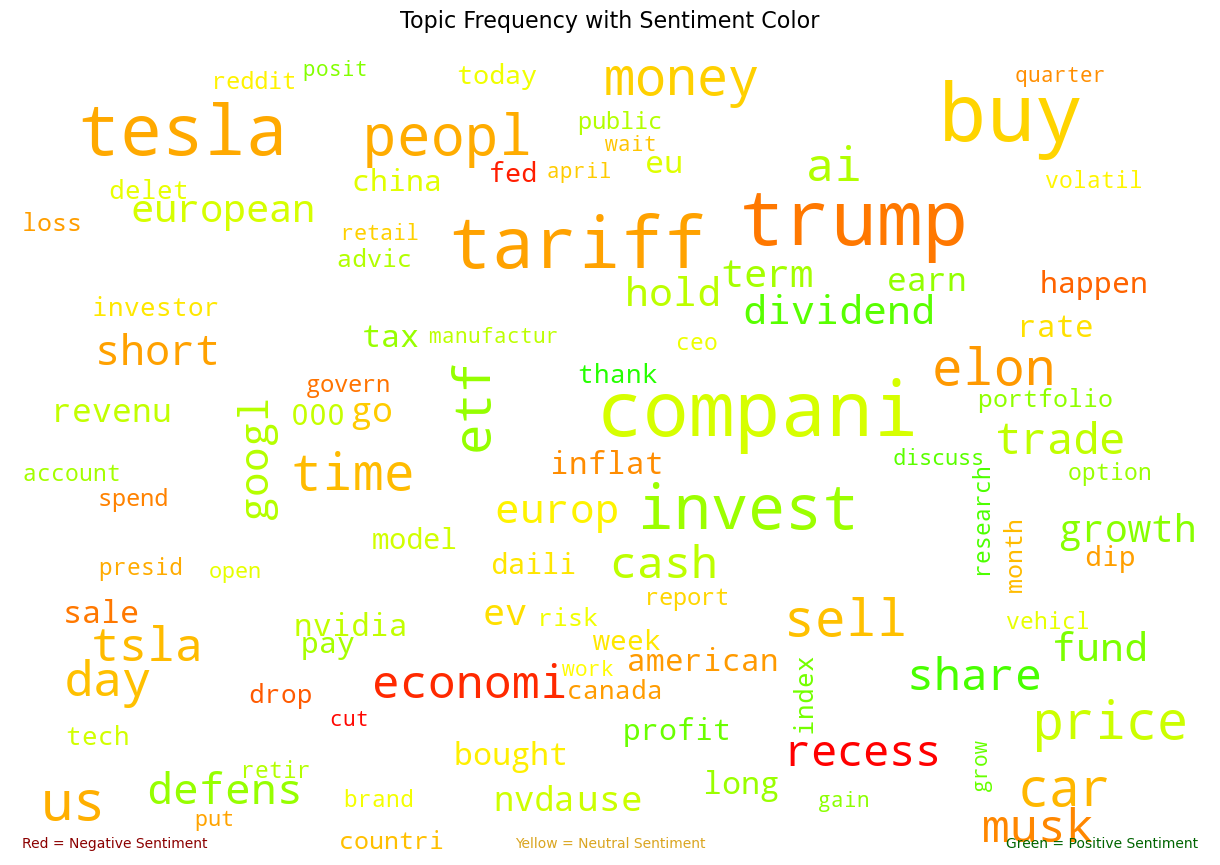

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Initialize an empty dictionary for word cloud
top_topics = topic_counts.most_common(150)
wordcloud_topics = {}

# Your topic data using frequency for size and sentiment for color
for topic, count in top_topics:
    # Use the count (frequency) as the value for sizing
    wordcloud_topics[topic] = count  # This will make size based on frequency

# Get sentiment values for coloring
sentiment_dict = {topic: topic_analysis[topic]['avg_sentiment'] for topic, _ in top_topics}
min_sentiment = min(sentiment_dict.values())
max_sentiment = max(sentiment_dict.values())

# Color function based on sentiment - red to yellow to green
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    sentiment = sentiment_dict.get(word, 0)
    # Normalize sentiment to [0,1]
    normalized = (sentiment - min_sentiment) / (max_sentiment - min_sentiment) if max_sentiment > min_sentiment else 0.5
    
    # Convert to a color (red to yellow to green)
    if normalized < 0.5:
        # Red to yellow (bad to neutral)
        # Increase green component as we move toward middle
        return f"rgb(255, {int(255 * normalized * 2)}, 0)"
    else:
        # Yellow to green (neutral to good)
        # Decrease red component as we move toward good
        return f"rgb({int(255 * (1 - (normalized - 0.5) * 2))}, 255, 0)"

# Create a WordCloud object
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    color_func=color_func,  # Custom color function based on sentiment
    prefer_horizontal=0.9,  # Allow some vertical words for better packing
    max_words=100,
    relative_scaling=0.6,  # Balance frequency vs. ranking
    min_font_size=8,
    max_font_size=80,
    random_state=42  # Fixed seed for reproducibility
).generate_from_frequencies(wordcloud_topics)

# Create a figure for the word cloud
plt.figure(figsize=(12, 8), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Add a title and explain the color scheme
plt.title("Topic Frequency with Sentiment Color", fontsize=16, pad=20)

# Add a small color legend
ax = plt.gca()
ax.text(0.01, 0.01, "Red = Negative Sentiment", transform=ax.transAxes, 
        fontsize=10, color='darkred', ha='left')
ax.text(0.5, 0.01, "Yellow = Neutral Sentiment", transform=ax.transAxes, 
        fontsize=10, color='goldenrod', ha='center')
ax.text(0.99, 0.01, "Green = Positive Sentiment", transform=ax.transAxes, 
        fontsize=10, color='darkgreen', ha='right')

# Save the generated image as a PNG file
wordcloud.to_file("topic_frequency_wordcloud.png")
print("Word cloud saved as 'topic_frequency_wordcloud.png'")